## Import

In [104]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.distributions.normal import Normal
from torch import nn, optim  
from torch.utils.data import DataLoader, Dataset     
import torch.nn.functional as F  
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from torch.nn.parameter import Parameter


from sklearn.model_selection import train_test_split

from tqdm import tqdm
import random
import copy

import copy

In [151]:
# data import
df_s = pd.read_csv('df_s_convex_concave.csv')
df_s_true = pd.read_csv('df_s_true_convex_concave.csv')
df_t = pd.read_csv('df_t_convex_concave.csv')
df_t_true = pd.read_csv('df_t_true_convex_concave.csv')
df_t_labeled = pd.read_csv('df_t_labeled_true_convex_concave.csv')
surrogate_domain_num = 4
for i in range(surrogate_domain_num):
    exec(f"df_t{i} = pd.read_csv('df_t{i}_convex_concave.csv')")
df_t_labeled = df_t_labeled.iloc[[0,2,4,6]].reset_index(drop=True)

In [152]:
# data preprocessing
x_s = torch.tensor(df_s['X']).reshape(-1,1).type(torch.float32)
x_t =torch.tensor(df_t['X']).reshape(-1,1).type(torch.float32)
x_t_labeled =torch.tensor(df_t_labeled['X']).reshape(-1,1).type(torch.float32)
y_s = torch.tensor(df_s['Y']).reshape(-1,1).type(torch.float32)
y_t =torch.tensor(df_t['Y']).reshape(-1,1).type(torch.float32)
y_t_labeled =torch.tensor(df_t_labeled['Y']).reshape(-1,1).type(torch.float32)
y_s_true = torch.tensor(df_s_true['Y']).reshape(-1,1).type(torch.float32)
y_t_true =torch.tensor(df_t_true['Y']).reshape(-1,1).type(torch.float32)
for i in range(surrogate_domain_num):
    exec(f"x_t{i} = torch.tensor(df_t{i}['X']).reshape(-1,1).type(torch.float32)")
    exec(f"y_t{i} = copy.deepcopy(y_s)")
exec(f"x_t{surrogate_domain_num} = copy.deepcopy(x_s)")
exec(f"y_t{surrogate_domain_num} = copy.deepcopy(y_s)")

## MAML

In [161]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(1, 64)
        self.relu = nn.ELU()
        self.h2 = nn.Linear(64, 64)
        self.h3 = nn.Linear(64, 64)
        self.reg = nn.Linear(64, 1)
        # self.drop1 = nn.Dropout()
        # self.drop2 = nn.Dropout()
        
    def forward(self, x):
        x = self.h1(x)
        x = self.relu(x)
        x = self.h2(x)
        x = self.relu(x)
        x = self.h3(x)
        x = self.relu(x)
        x = self.reg(x)

        return x

### Meta-Learning

In [177]:
parent_model = MLP()
optimizer = optim.Adam(parent_model.parameters(), lr=0.001)
domain_num = 4 + 1
batch_domain = 5
batch_num = 4
best_loss = 100000
best_parent_model = None

for outer_epoch in range(10000):
    parent_model.eval()
    
    batch_domain_list = random.sample(range(domain_num), batch_domain)
    
    for batch_domain_idx in batch_domain_list:
        batch_data_list = random.sample(range(len(x_t0)), len(x_t0))
        batch_train_data_list = batch_data_list[:batch_num]
        batch_val_data_list = batch_data_list[batch_num:]
        exec(f"child_model{batch_domain_idx} = copy.deepcopy(parent_model)")
        exec(f"optimizer{batch_domain_idx} = optim.Adam(child_model{batch_domain_idx}.parameters(), lr = 0.01)")
        exec(f"child_model{batch_domain_idx}.train()")
        exec(f"optimizer{batch_domain_idx}.zero_grad()")
        for inner_epoch in range(10):
            exec(f"temp_loss = torch.nn.functional.mse_loss(child_model{batch_domain_idx}(x_t{batch_domain_idx}[batch_train_data_list]), x_s[batch_train_data_list])")
            temp_loss.backward()
            exec(f"optimizer{batch_domain_idx}.step()")
    
    parent_model.train()
    optimizer.zero_grad()
    loss = 0
    for batch_domain_idx in batch_domain_list:
        exec(f"loss += torch.nn.functional.mse_loss(child_model{batch_domain_idx}(x_t{batch_domain_idx}[batch_val_data_list]), x_s[batch_val_data_list])")
    loss /= batch_domain
    if best_loss > loss:
        best_loss = loss
        best_parent_model = copy.deepcopy(parent_model)
        print(f"epoch : {outer_epoch}, train loss : {loss.detach().item()}")
    loss.backward()
    optimizer.step()

epoch : 0, train loss : 44.43609619140625
epoch : 3, train loss : 38.929786682128906
epoch : 8, train loss : 37.49713134765625
epoch : 43, train loss : 27.08652687072754
epoch : 193, train loss : 26.70591163635254
epoch : 319, train loss : 23.821191787719727


KeyboardInterrupt: 

### Meta-Inference

In [138]:
target_model = copy.deepcopy(best_parent_model)
target_model.train()
target_optimizer = optim.Adam(target_model.parameters(), lr=0.001)
train_loss_list = []
test_loss_list = []
true_test_loss_list = []
model_list = []
for i in tqdm(range(100)):
    model_list.append(copy.deepcopy(target_model))
    target_model.eval()
    target_model(x_t)
    test_loss_list.append(torch.nn.functional.mse_loss(target_model(x_t), y_t).detach().item())
    true_test_loss_list.append(torch.nn.functional.mse_loss(target_model(x_t), y_t_true).detach().item())

    target_model.train()
    target_optimizer.zero_grad()
    train_loss = torch.nn.functional.mse_loss(target_model(x_t_labeled), y_t_labeled)
    train_loss.backward()
    target_optimizer.step()
    train_loss_list.append(train_loss.detach().item())

100%|██████████| 100/100 [00:00<00:00, 284.44it/s]


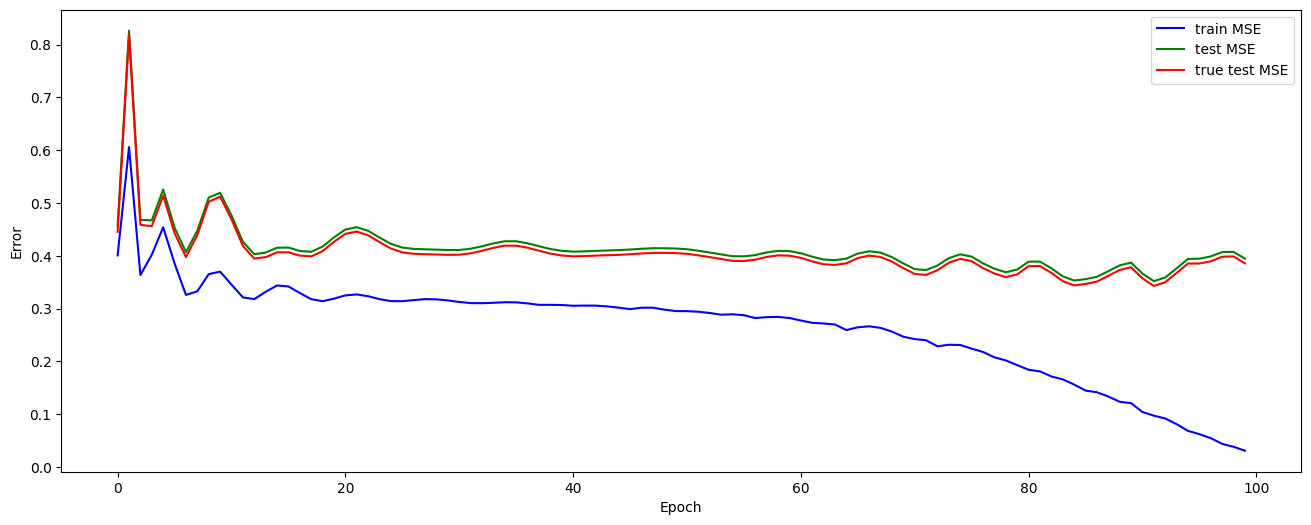

In [139]:
plt.figure(figsize=(16,6))
plt.plot(range(len(train_loss_list)), train_loss_list, c='blue', label='train MSE', zorder=1)
plt.plot(range(len(train_loss_list)), test_loss_list, c='green', label='test MSE', zorder=2)
plt.plot(range(len(train_loss_list)), true_test_loss_list, c='red', label='true test MSE', zorder=3)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.show()

test mse : 0.4887503981590271, denoised test mse : 0.47721776366233826


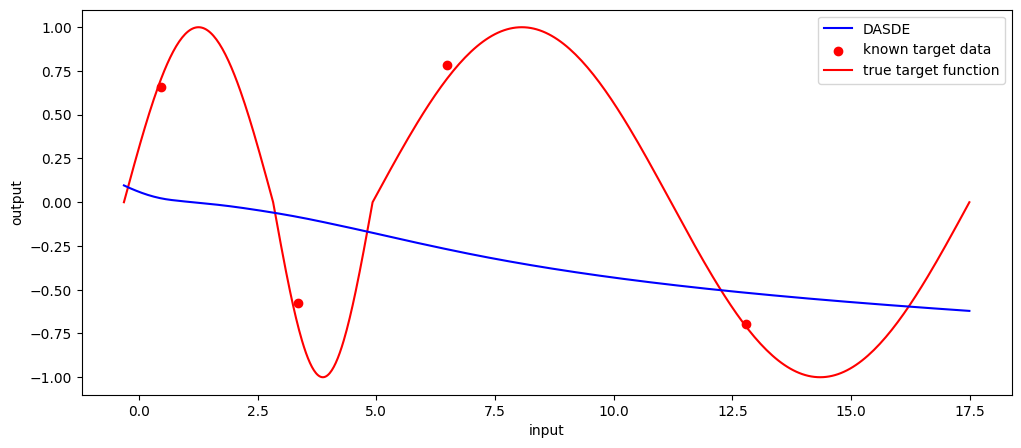

In [126]:
plt.figure(figsize=(12,5))
plt.plot(x_t, target_model(x_t).detach().numpy(), c='blue', label='DASDE', zorder=2)
plt.scatter(x_t_labeled, y_t_labeled, c='red', label='known target data', zorder=1)
plt.plot(x_t, y_t_true, c='red', label='true target function', zorder=1)
plt.xlabel('input')
plt.ylabel('output')
plt.legend()
print(f"test mse : {test_loss_list[-1]}, denoised test mse : {true_test_loss_list[-1]}")

  1%|          | 6/1000 [00:00<00:18, 53.24it/s]

100%|██████████| 1000/1000 [00:13<00:00, 71.52it/s]


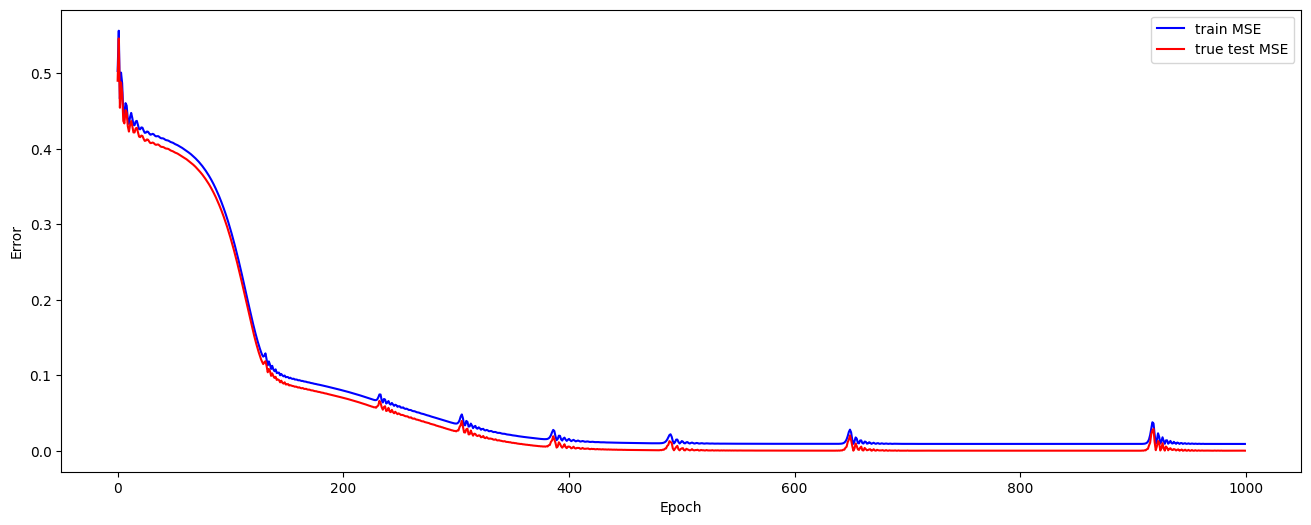

denoised test mse : 0.00027523201424628496


In [167]:
mlp_model = MLP()
mlp_model.train()
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
train_loss_list = []
test_loss_list = []
true_test_loss_list = []
model_list = []
for i in tqdm(range(1000)):
    model_list.append(copy.deepcopy(mlp_model))
    mlp_model.eval()
    true_test_loss_list.append(torch.nn.functional.mse_loss(mlp_model(x_s), y_s_true).detach().item())

    model_list.append(copy.deepcopy(mlp_model))
    mlp_model.eval()
    mlp_model(x_t)
    mlp_model.train()
    mlp_optimizer.zero_grad()
    train_loss = torch.nn.functional.mse_loss(mlp_model(x_s), y_s)
    
    train_loss.backward()
    mlp_optimizer.step()
    train_loss_list.append(train_loss.detach().item())

plt.figure(figsize=(16,6))
plt.plot(range(len(train_loss_list)), train_loss_list, c='blue', label='train MSE', zorder=1)
plt.plot(range(len(train_loss_list)), true_test_loss_list, c='red', label='true test MSE', zorder=3)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.show()
print(f"denoised test mse : {true_test_loss_list[-1]}")

100%|██████████| 100/100 [00:00<00:00, 245.07it/s]


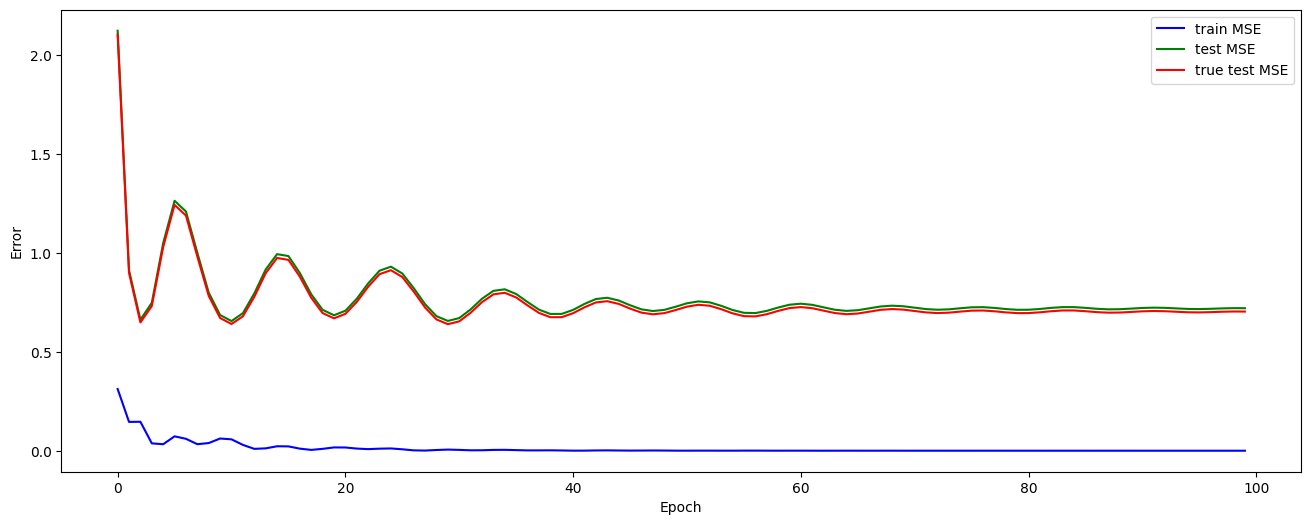

In [172]:
few_shot_learned_mlp_model = copy.deepcopy(mlp_model)
mlp_optimizer = optim.Adam(few_shot_learned_mlp_model.parameters(), lr=0.001)
train_loss_list = []
test_loss_list = []
true_test_loss_list = []
model_list = []
for i in tqdm(range(100)):
    model_list.append(copy.deepcopy(few_shot_learned_mlp_model))
    few_shot_learned_mlp_model.eval()
    test_loss_list.append(torch.nn.functional.mse_loss(few_shot_learned_mlp_model(x_t), y_t).detach().item())
    true_test_loss_list.append(torch.nn.functional.mse_loss(few_shot_learned_mlp_model(x_t), y_t_true).detach().item())

    few_shot_learned_mlp_model.train()
    mlp_optimizer.zero_grad()
    train_loss = torch.nn.functional.mse_loss(few_shot_learned_mlp_model(x_t_labeled), y_t_labeled)
    # train_loss = torch.nn.functional.mse_loss(few_shot_learned_mlp_model(x_t), y_t)
    
    train_loss.backward()
    mlp_optimizer.step()
    train_loss_list.append(train_loss.detach().item())

plt.figure(figsize=(16,6))
plt.plot(range(len(train_loss_list)), train_loss_list, c='blue', label='train MSE', zorder=1)
plt.plot(range(len(train_loss_list)), test_loss_list, c='green', label='test MSE', zorder=2)
plt.plot(range(len(train_loss_list)), true_test_loss_list, c='red', label='true test MSE', zorder=3)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.show()

test mse : 0.7210018038749695, denoised test mse : 0.7040337324142456


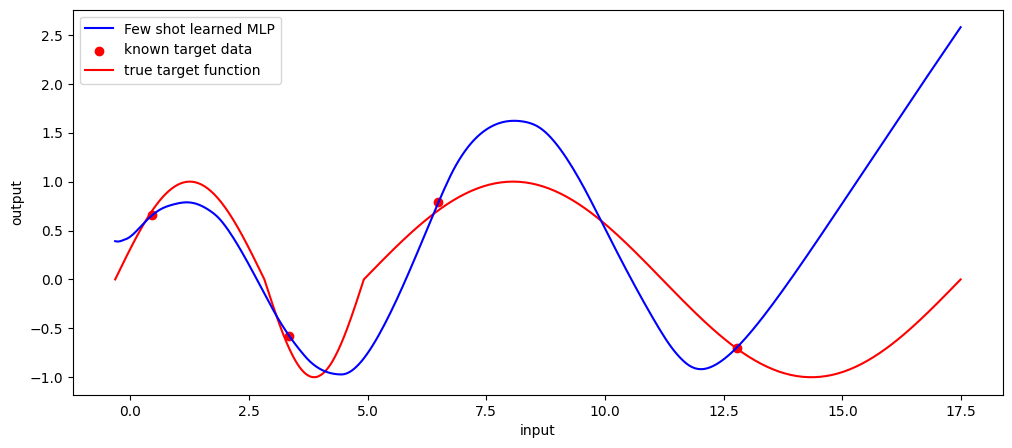

In [173]:
plt.figure(figsize=(12,5))
plt.plot(x_t, few_shot_learned_mlp_model(x_t).detach().numpy(), c='blue', label='Few shot learned MLP', zorder=2)
plt.scatter(x_t_labeled, y_t_labeled, c='red', label='known target data', zorder=1)
plt.plot(x_t, y_t_true, c='red', label='true target function', zorder=1)
plt.xlabel('input')
plt.ylabel('output')
plt.legend()
print(f"test mse : {test_loss_list[-1]}, denoised test mse : {true_test_loss_list[-1]}")